In [26]:
import os
import numpy as np

import corner
import matplotlib as mpl
import matplotlib.pyplot as plt


In [27]:
dir_inp = './output/mcmc5'

In [28]:
def find_substring(string, element1, element2):
    start = string.find(element1) + len(element1)
    end = string.find(element2, start)
    return string[start:end].strip()

def get_sample(chains,ind1,ind2,flat):
    niter, nwalkers, ndim = chains.shape
    if flat:
        # collect samples
        samples = chains[ind1:].reshape((-1, ndim))  # flatten niter*nwalkers
        # take every ind2-th sample
        idx = np.arange(0, samples.shape[0], ind2, dtype=int)
        samples = samples[idx]
        return samples
    else:
        return chains[ind1::ind2]  # if not flat, maybe thin directly

def get_sample_2d(array, ind1, ind2, flat):
    niter, nwalkers = array.shape
    if flat:
        samples = array[ind1:].reshape(-1)  # flatten
        idx = np.arange(0, samples.shape[0], ind2, dtype=int)
        return samples[idx]
    else:
        return array[ind1::ind2]


In [29]:
# Load the data

log_prior = np.load(os.path.join(dir_inp,'log_prior.npy'))
log_posterior = np.load(os.path.join(dir_inp,'log_posterior.npy'))
chains = np.load(os.path.join(dir_inp,'chains.npy'))

log_likelihood = log_posterior - log_prior

iteration, autocorr, n50 = np.loadtxt(os.path.join(dir_inp,'autocorr_time.txt')).T
best_params = np.loadtxt(os.path.join(dir_inp,'best_params.txt'),dtype=str).T

labels = best_params[0]
params_mean, params_sigma = np.array(best_params[1],dtype=float), np.array(best_params[2],dtype=float)
best_values = np.array(best_params[3],dtype=float)
err1, err2 = np.array(best_params[4],dtype=float), np.array(best_params[5],dtype=float)

with open(os.path.join(dir_inp,'autocorr_time.txt'),"r") as f:
    header = f.readline()
    taum = int(find_substring(header, 'taum =', ','))

ind1, ind2 = 2*taum, taum/2


/tmp/ipykernel_149050/2961895010.py:10: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  best_params = np.loadtxt(os.path.join(dir_inp,'best_params.txt'),dtype=str).T


In [30]:
niter, nwalkers, ndim = chains.shape

good_samples = get_sample(chains,ind1,ind2,flat=True)
good_likelihood = get_sample_2d(log_likelihood,ind1,ind2,flat=True)


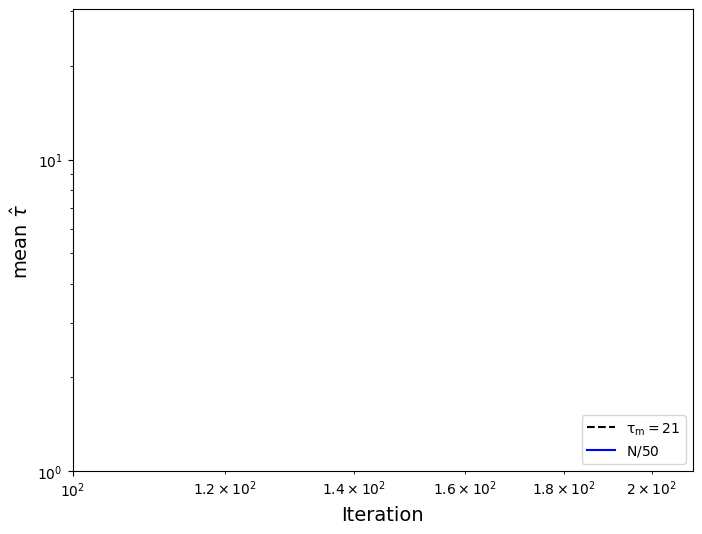

In [31]:
# Autocorrelation time
f, ax = plt.subplots(1,1,figsize=(8,6))
ax.loglog(iteration, autocorr, ls='--', c='k',label=r'$\mathrm{\tau_m=}$'+str(round(taum,0)))
ax.loglog(iteration, n50, c='b',label=r'$\mathrm{N/50}$')
ax.set_xlim([100,niter])
ax.set_ylim([1, 1.5*np.nanmax(autocorr)])
ax.set_xlabel("Iteration",fontsize=14)
ax.set_ylabel(r"mean $\hat{\tau}$",fontsize=14)
plt.legend(loc=4)
plt.savefig(os.path.join(dir_inp,'tau.png'))


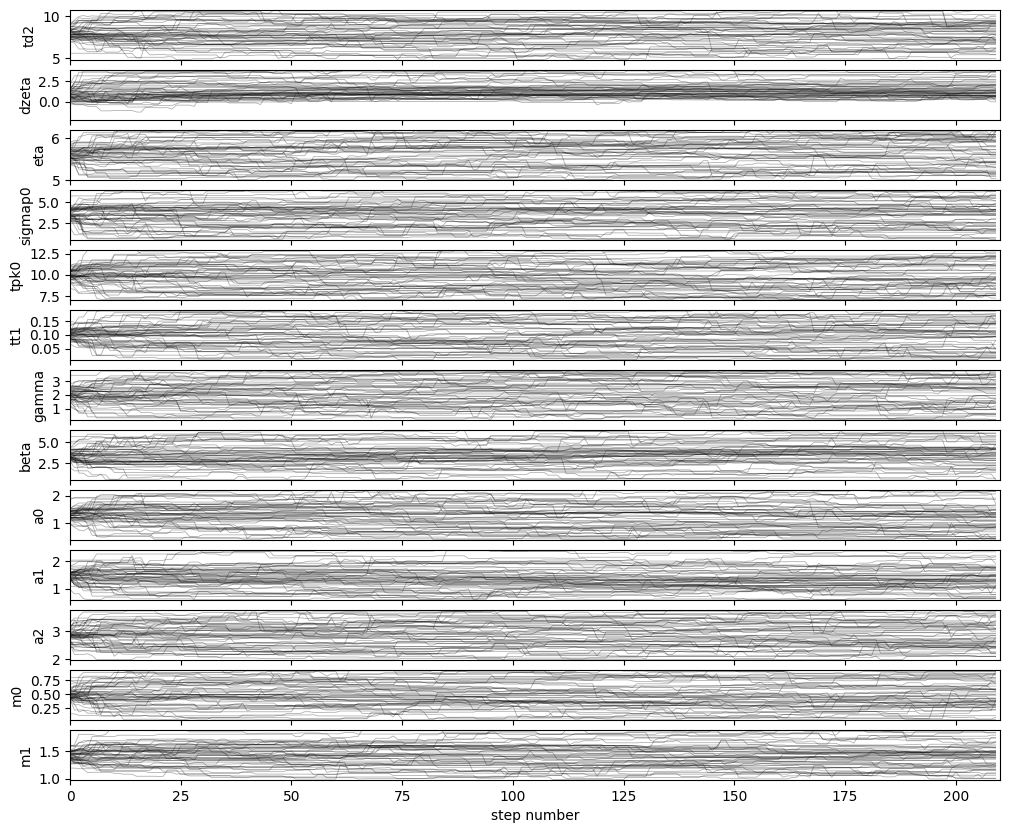

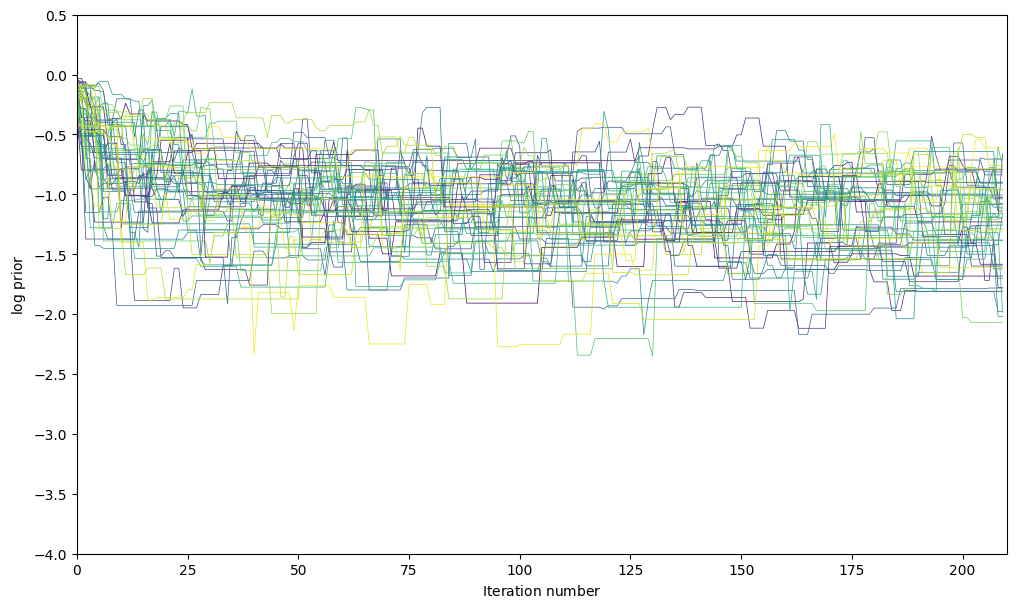

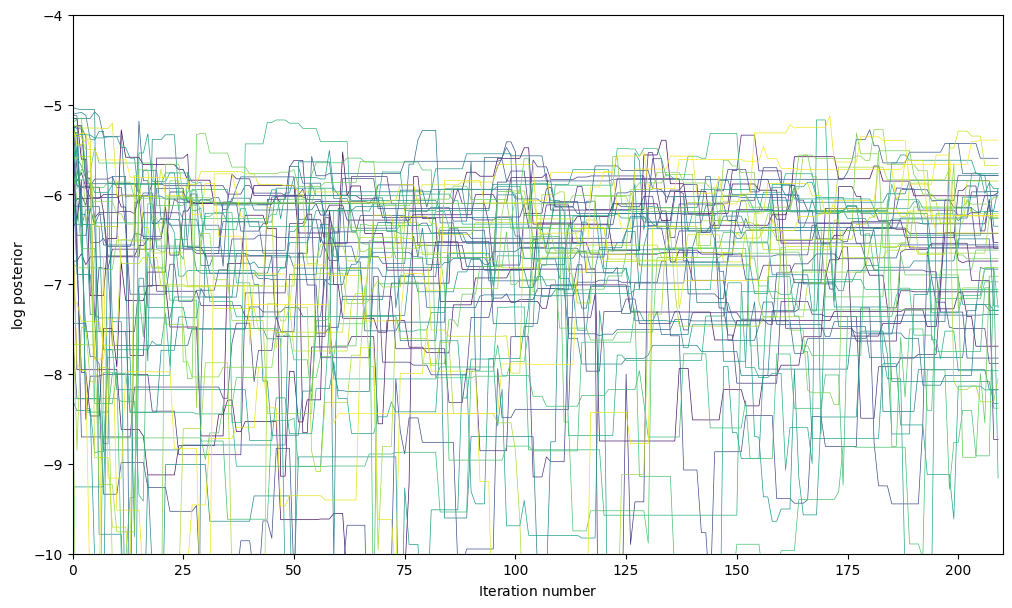

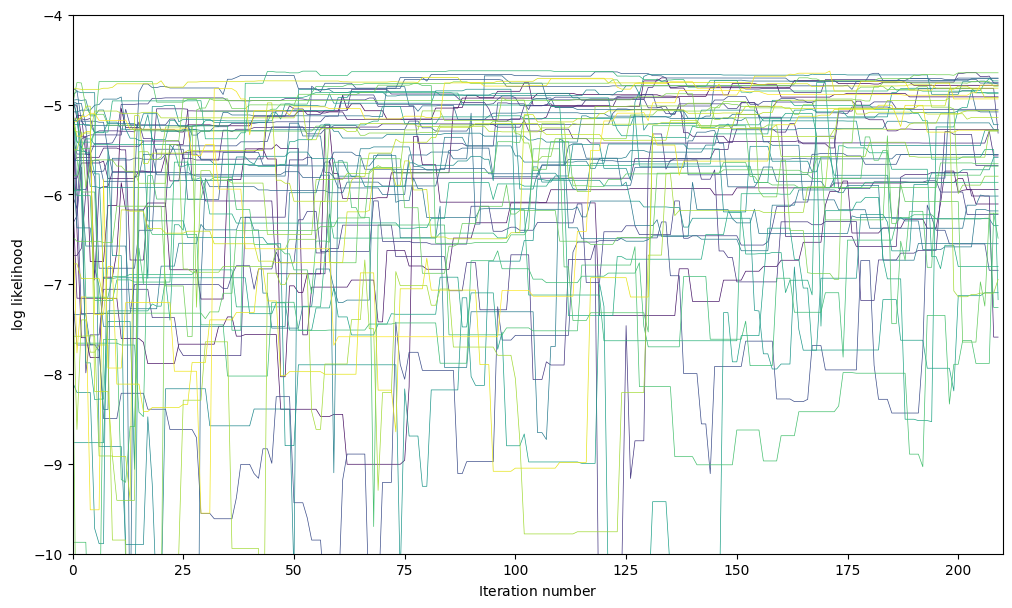

In [32]:
chain_cmap = mpl.colormaps['viridis']
chain_colors = chain_cmap(np.linspace(0,1,nwalkers))

ycoords = []
for i in range(ndim):
    ycoords.append((params_mean[i]-3*params_sigma[i],params_mean[i]+3*params_sigma[i]))


# All parameters in one plot
fig, axes = plt.subplots(ndim, figsize=(12, 10), sharex=True)
for i in range(ndim):
    ax = axes[i]
    for k in range(nwalkers):
        ax.plot(chains[:, k, i], lw=0.6, c='k', alpha=0.3)
    ax.set_xlim(0, len(chains))
    ax.set_ylabel(labels[i])
    ax.set_ylim(ycoords[i][0],ycoords[i][1])
axes[-1].set_xlabel("step number")
plt.savefig(os.path.join(dir_inp,'parameters.png'))

# Prior in chains
plt.figure(figsize=(12,7))
for k in range(nwalkers):
    plt.plot(log_prior[:,k],lw=0.5,c=chain_colors[k])
plt.ylabel(r'$\mathrm{log \ prior}$')
plt.xlabel(r'$\mathrm{Iteration \ number}$')
plt.xlim(0,niter)
plt.ylim(-4,0.5)
plt.savefig(os.path.join(dir_inp,'log_prior_chains.png'))

# Posterior in chains
plt.figure(figsize=(12,7))
for k in range(nwalkers):
    plt.plot(log_posterior[:,k],lw=0.5,c=chain_colors[k])
plt.ylabel(r'$\mathrm{log \ posterior}$')
plt.xlabel(r'$\mathrm{Iteration \ number}$')
plt.xlim(0,niter)
plt.ylim(-10,-4)
plt.savefig(os.path.join(dir_inp,'log_posterior_chains.png'))

plt.figure(figsize=(12,7))
for k in range(nwalkers):
    plt.plot(log_likelihood[:,k],lw=0.5,c=chain_colors[k])
plt.ylabel(r'$\mathrm{log \ likelihood}$')
plt.xlabel(r'$\mathrm{Iteration \ number}$')
plt.xlim(0,niter)
plt.ylim(-10,-4)
plt.savefig(os.path.join(dir_inp,'log_likelihood_chains.png'))

# Each parameter separately, all iterations and after burn-in
for i in range(ndim):
    plt.figure(figsize=(12,7))
    for k in range(nwalkers):
        plt.plot(chains[:,k,i],lw=0.5,c=chain_colors[k])
    plt.ylabel(labels[i])
    plt.xlabel(r'$\mathrm{Iteration \ number}$')
    plt.axis([0,niter,ycoords[i][0],ycoords[i][1]])
    plt.savefig(os.path.join(dir_inp,''.join((labels[i],'_all.png'))))
    plt.close()

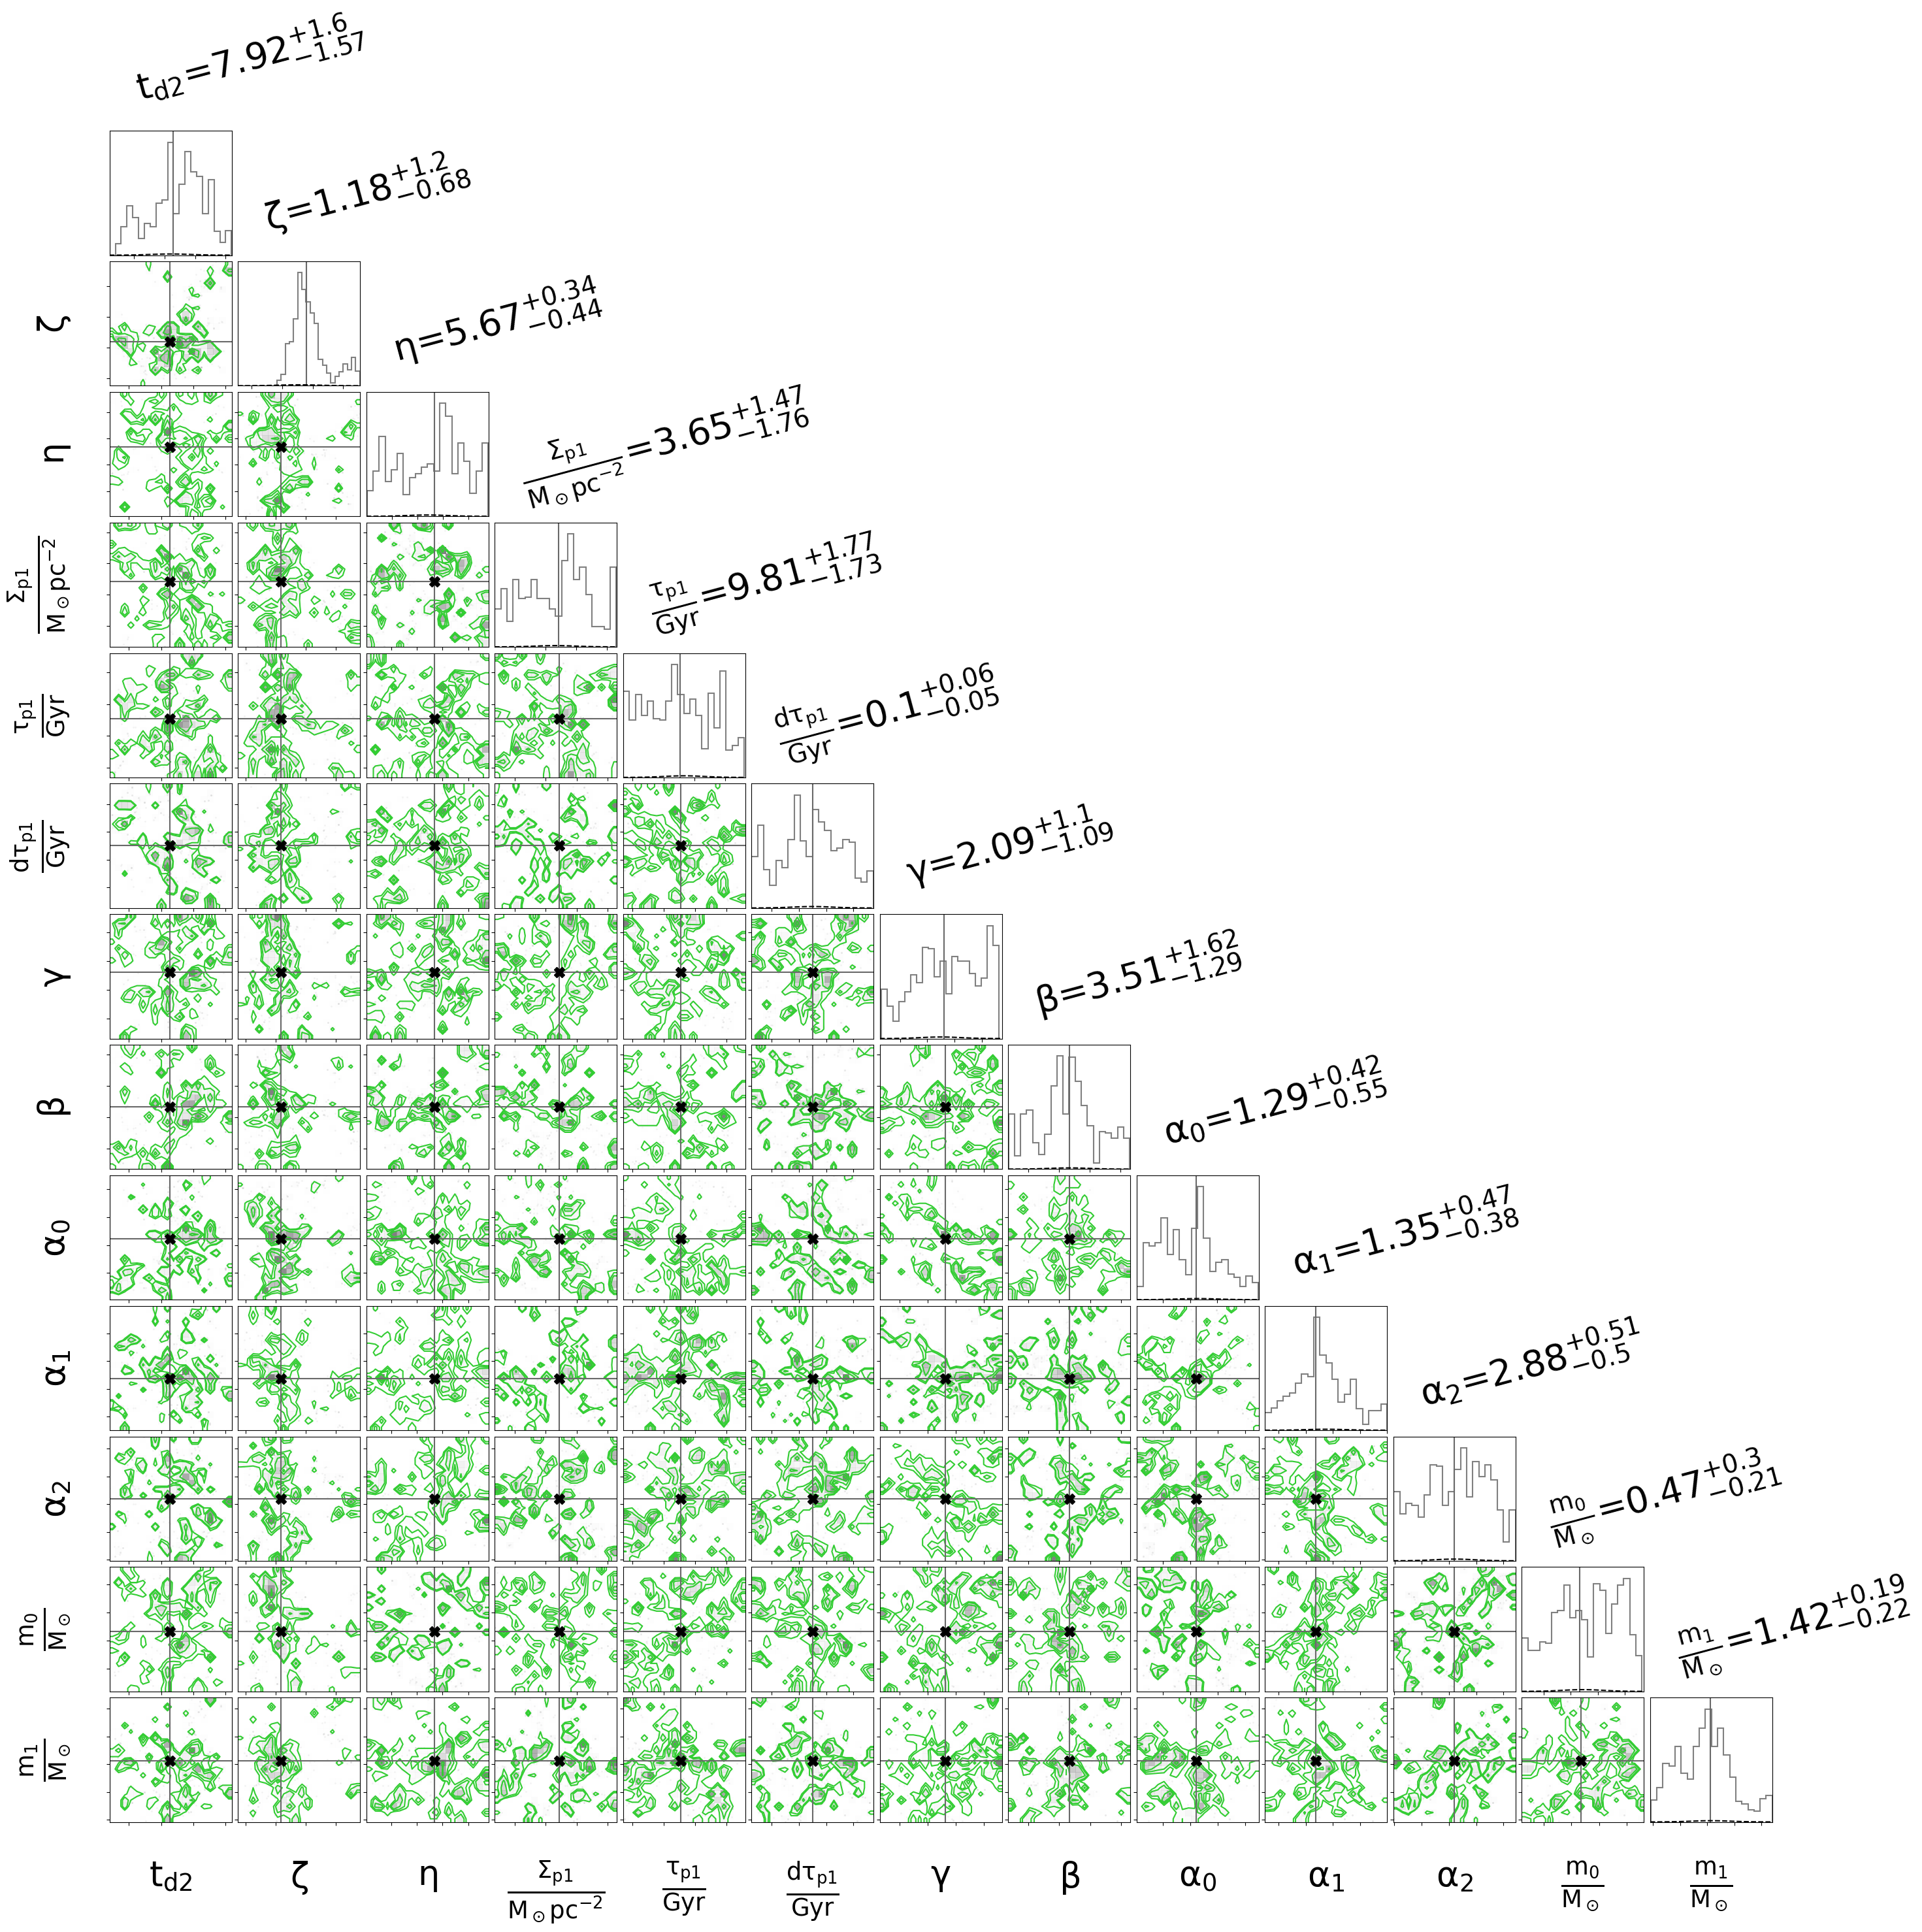

In [33]:
# Corner plot, all iterations and after burn-in

param_props = {
    'td2':{'l':r'$\mathrm{t_{d2}}$','r':2},
    'dzeta':{'l':r'$\mathrm{\zeta}$','r':2},
    'eta':{'l':r'$\mathrm{\eta}$','r':2},
    'sigmap0':{'l':r'$\mathrm{\frac{\Sigma_{p1}}{M_\odot pc^{-2}}}$','r':2},
    'tpk0':{'l':r'$\mathrm{\frac{\tau_{p1}}{Gyr}}$','r':2},
    'tt1':{'l':r'$\mathrm{\frac{d\tau_{p1}}{Gyr}}$','r':2},
    'gamma':{'l':r'$\mathrm{\gamma}$','r':2},
    'beta':{'l':r'$\mathrm{\beta}$','r':2},
    'a0':{'l':r'$\mathrm{\alpha_{0}}$','r':2},
    'a1':{'l':r'$\mathrm{\alpha_{1}}$','r':2},
    'a2':{'l':r'$\mathrm{\alpha_{2}}$','r':2},
    'm0':{'l':r'$\mathrm{\frac{m_{0}}{M_\odot}}$','r':2},
    'm1':{'l':r'$\mathrm{\frac{m_{1}}{M_\odot}}$','r':2}    
}

p_names = [param_props[key]['l'] for key in labels]
nround = [param_props[key]['r'] for key in labels]

ranges = [] 
for i in range(ndim):
    ranges.append((params_mean[i]-3*params_sigma[i],
                   params_mean[i]+3*params_sigma[i]))

# Full corner plot
fig = corner.corner(good_samples, labels=p_names,truths=best_values,truth_color='dimgrey',
                    label_kwargs={'fontsize':38},color='grey',hist_kwargs={'linewidth':1.5},
                    contour_kwargs={'colors':'limegreen'});
axes = np.array(fig.axes).reshape((ndim,ndim))
fig.subplots_adjust(bottom=0.04,left=0.04,top=0.945,right=0.93)
for i1 in range(ndim):
    for i2 in range(i1):
        ax = axes[i1,i2]
        ax.plot(best_values[i2],best_values[i1],marker='X',markersize=12,c='k')
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])    
    
    likelihood = good_likelihood.T[i1]
    histogram = np.histogram(likelihood, bins=20)
    histogram_normed = histogram[0].astype(float) / np.amax(histogram[0]) # normlization on 1 
    ones = np.linspace(histogram[1][0],histogram[1][-1],len(histogram[1])-1)
    axes[i1,i1].hist(ones, bins=histogram[1],weights=histogram_normed,histtype='step',lw=1.5,color='turquoise')                              
    
    x = np.linspace(ranges[i1][0],ranges[i1][1],50)
    if i1==120 or i1==150:
        #mean = 13 - fitmode['parmean'][i1]
        #prior = np.exp(-(x-mean)**2/2/fitmode['parsigm'][i1]**2) 
        pass
    else:
        prior = np.exp(-(x-params_mean[i1])**2/2/params_sigma[i1]**2) 

    axes[i1,i1].plot(x,prior/np.amax(prior),c='k',ls='--')
    axes[i1,i1].xaxis.set_ticklabels([])
    axes[i1,i1].set_xlim(ranges[i1][0],ranges[i1][1])
    pos = axes[i1,i1].get_position()
    title = r"${{{0}}}_{{-{1}}}^{{+{2}}}$"
    label = p_names[i1] + '=' + title.format(round(best_values[i1],nround[i1]),
                                            round(err1[i1],nround[i1]),round(err2[i1],nround[i1]))
    fig.text(pos.x0+pos.width/4,pos.y0+1.25*pos.height,label,fontsize=40,rotation=15, rotation_mode='anchor')

#fig.text(0.65,0.9,'$\mathrm{Local \ normalisations}$',fontsize=80,color='firebrick')
#fig.text(0.65,0.85,'$\mathrm{Kinematic \ parameters}$',fontsize=80,color='olivedrab')
#fig.text(0.65,0.8,'$\mathrm{SFR \ shape}$',fontsize=80,color='darkorange')
#fig.text(0.65,0.75,'$\mathrm{IMF \ parameters}$',fontsize=80,color='steelblue')

fig.savefig(os.path.join(dir_inp,'corner.png'))
#fig.savefig('corner_full_wd.pdf')
